## Calculate relative humidity from specific humidity

In [12]:
import xarray as xr
from metpy.units import units as mpunits
from metpy import calc as mpcalc
from dask.diagnostics import ProgressBar

In [13]:
# from distributed import Client, LocalCluster, progress
# cluster = LocalCluster(
#     threads_per_worker=1,
#     n_workers=1,
#     dashboard_address=8644,
#     processes=False,
# )
# client = Client(cluster)
# client

In [14]:
# Point to model data
rootdir = '/local/ss23/GFDL_LEs/ATM/RCP85/'
suffix = '.rcp85.ens101.1950_2100.nc'
variables = ['sphum_k24','ps','t_ref']
ds = xr.Dataset()
for var in variables:
    print(var)
    ds[var] = xr.open_dataarray(rootdir+var+suffix,chunks={'time':1}).squeeze()

sphum_k24
ps
t_ref


In [15]:
# Assign units to variables
ds['t_ref'] = ds['t_ref'] * mpunits.degK
ds['ps'] = ds['ps'] * mpunits.Pa

In [16]:
# Wrap MetPy function into an apply_ufunc calculation to work with dask array
def mpcalc_relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure):
    return xr.apply_ufunc(mpcalc.relative_humidity_from_specific_humidity,
                            specific_humidity, temperature, pressure,
                            dask='parallelized',output_dtypes=[specific_humidity.dtype])

In [17]:
ds = ds.sel(time='1980-01-01')
relhum = mpcalc_relative_humidity_from_specific_humidity(ds['sphum_k24'],ds['t_ref'],ds['ps'])
relhum.name = 'relhum'

In [18]:
with ProgressBar():
    relhum.load()

[########################################] | 100% Completed |  0.1s


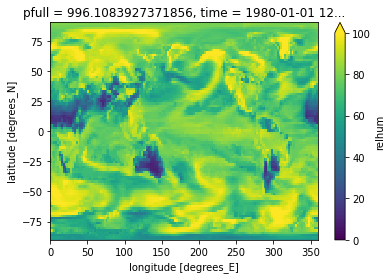

In [21]:
(100*relhum).plot(vmin=0,vmax=100)